In [1]:
import torch 
from torch import nn 
from tianwen import clip 
from tianwen import clip_model
from PIL import Image 
from matplotlib import pyplot as plt 
from d2l import torch as d2l

from tianwen import Data_Loader

In [2]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, transform = clip.load("RN50")

In [4]:
texts = [
    "a bottle of poison.",
    "a photo of fruit.",
    "white wedding dress."
]
tokens = clip.tokenize(texts)

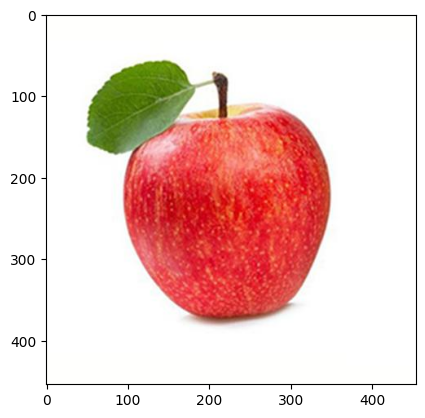

In [5]:
image_dir = '../data/fruit_class/train/apple/apple (1).jpg'
image = Image.open(image_dir)
plt.imshow(image)
img_tensor = transform(image).unsqueeze(0)

In [6]:
device = torch.device('cuda')
img_tensor, tokens = img_tensor.to(device), tokens.to(device)
image_logits, _ = model(img_tensor, tokens)
answer = texts[image_logits.argmax()]
outputs = torch.softmax(image_logits.squeeze(0), dim=0).cpu().detach().numpy().tolist()
print(outputs)
print(f"the most match expression is: {answer}");

[0.0003859996795654297, 0.99951171875, 5.304813385009766e-06]
the most match expression is: a photo of fruit.


/home/shilin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/functional.py:5463: UserWarning: Memory Efficient Attention requires the attn_mask to be aligned to, 8 elements. Prior to calling SDPA, pad the last dimension of the attn_mask to be at least a multiple of 8 and then slice the attn_mask to the original size. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:551.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [7]:
def evaluate_accuracy_gpu(net, data_iter, text_tokens, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            output, _ = net(X, text_tokens)
            metric.add(d2l.accuracy(output, y), d2l.size(y))
    return metric[0] / metric[1]

def Fruit_classes():
    return ["apple", "banane", "durian", "grape", "orange"]

data_dir = '../data/fruit_class/'
batch_size = 64

# image 处理
transform = clip._transform(224)
image_train_iter, image_test_iter = Data_Loader(batch_size, data_dir, transform)   # image->(32, 3, 224, 224) label->(32)


# text 处理
fruit_classes = Fruit_classes()

def text_classifier(imagenet_classes):
    for i, class_name in enumerate(imagenet_classes):
        text = [f"a photo of {class_name}"]
        token = clip.tokenize(text, 77).cuda()
        
        if i == 0:
            text_tokens = token
        else:
            text_tokens = torch.cat((text_tokens, token), dim=0)
    return torch.tensor(text_tokens)

text_tokens = text_classifier(fruit_classes)   # text_tokens -> (1000, context_length)

test_acc = evaluate_accuracy_gpu(model, image_test_iter, text_tokens)
print(f'{test_acc:.5f}');

/tmp/ipykernel_57966/1739455901.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text_tokens)


0.99411
